In [ ]:
# Install necessary modules
pip install torch torchvision matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Import necessary libraries
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

In [ ]:
# Paths to datasets
annotations_df = pd.read_csv('/kaggle/input/urinary-sediment/annotations_df.csv')
images_df = pd.read_pickle('/kaggle/input/urinary-sediment/images_df.pkl')

In [3]:
# Remove 'Unnamed: 0' column from annotations_df
if 'Unnamed: 0' in annotations_df.columns:
  annotations_df = annotations_df.drop('Unnamed: 0', axis=1)

# Remove extensions from 'ImageName' column in images_df
images_df['ImageName'] = images_df['ImageName'].str.split('.').str[0]

In [4]:
annotations_df.head(), images_df.head()

(  ImageName Subset   Label  xmin  ymin  xmax  ymax
 0   nh00005   test  mycete   642    29   684    73
 1   nh00005   test   leuko   496    41   547   103
 2   nh00005   test  mycete   234   250   312   314
 3   nh00005   test   leuko   308   293   344   336
 4   nh00005   test   leuko   540   516   576   556,
    ImageName                                          ImageData
 4    nh00005  [[[216, 214, 204], [215, 213, 203], [214, 211,...
 9    nh00010  [[[218, 216, 205], [219, 217, 206], [218, 216,...
 14   nh00015  [[[219, 211, 204], [219, 211, 204], [219, 213,...
 19   nh00020  [[[230, 215, 212], [229, 214, 211], [227, 214,...
 24   nh00025  [[[222, 218, 207], [224, 218, 207], [223, 213,...)

In [5]:
# Ensure that only images present in both DataFrames are considered
common_names = set(annotations_df['ImageName']).intersection(set(images_df['ImageName']))

# Filter both DataFrames to include only common names
filtered_annotations_df = annotations_df[annotations_df['ImageName'].isin(common_names)]
filtered_images_df = images_df[images_df['ImageName'].isin(common_names)]

In [6]:
filtered_annotations_df.head()

,ImageName,Subset,Label,xmin,ymin,xmax,ymax
0,nh00005,test,mycete,642,29,684,73
1,nh00005,test,leuko,496,41,547,103
2,nh00005,test,mycete,234,250,312,314
3,nh00005,test,leuko,308,293,344,336
4,nh00005,test,leuko,540,516,576,556


In [7]:
filtered_images_df.head()

,ImageName,ImageData
4,nh00005,"[[[216, 214, 204], [215, 213, 203], [214, 211,..."
9,nh00010,"[[[218, 216, 205], [219, 217, 206], [218, 216,..."
14,nh00015,"[[[219, 211, 204], [219, 211, 204], [219, 213,..."
19,nh00020,"[[[230, 215, 212], [229, 214, 211], [227, 214,..."
24,nh00025,"[[[222, 218, 207], [224, 218, 207], [223, 213,..."


In [8]:
filtered_images_df.shape

(1084, 2)

In [9]:
class CustomDataset(Dataset):
    def __init__(self, annotations_df, images_df, label_map=None, transforms=None):
        """
        annotations_df: DataFrame containing ImageName, Label, and bounding box coordinates.
        images_df: DataFrame containing ImageName and ImageData.
        label_map: Optional dictionary mapping string labels to integers.
        transforms: Optional torchvision transforms to apply to the images.
        """
        self.annotations_df = annotations_df
        self.images_df = images_df
        self.transforms = transforms

        # Create a label mapping if not provided
        if label_map is None:
            unique_labels = annotations_df['Label'].unique()
            self.label_map = {label: idx + 1 for idx, label in enumerate(unique_labels)}  # Background starts at 0
        else:
            self.label_map = label_map

    def __len__(self):
        return len(self.images_df)

    def __getitem__(self, idx):
        # Get image data
        img_data = self.images_df.iloc[idx]
        img_name = img_data['ImageName']
        img_array = img_data['ImageData']
        image = Image.fromarray(img_array)

        # Get annotations for this image
        img_annotations = self.annotations_df[self.annotations_df['ImageName'] == os.path.splitext(img_name)[0]]

        # Extract bounding boxes and labels
        boxes = img_annotations[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
        labels = img_annotations['Label'].map(self.label_map).to_list()

        # Create masks from bounding boxes (binary mask for each box)
        height, width = img_array.shape[:2]
        masks = []
        for box in boxes:
            mask = torch.zeros((height, width), dtype=torch.uint8)
            x_min, y_min, x_max, y_max = map(int, box)
            mask[y_min:y_max, x_min:x_max] = 1
            masks.append(mask)
        masks = torch.stack(masks)

        # Create the target dictionary
        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'labels': torch.as_tensor(labels, dtype=torch.int64),
            'masks': masks
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target,

In [17]:
from torchvision.transforms import ToTensor, Compose, Resize

# Define transformations
transforms = Compose([
    Resize((600, 800)),  # Resize images to a fixed size (optional, depends on your data)
    ToTensor()           # Convert images to PyTorch tensors
])

In [18]:
# Initialize the dataset
dataset = CustomDataset(filtered_annotations_df, filtered_images_df, transforms=transforms)

# Check label mapping
print("Label Map:", dataset.label_map)

Label Map: {'mycete': 1, 'leuko': 2, 'eryth': 3, 'epithn': 4, 'cryst': 5, 'epith': 6, 'cast': 7}


In [19]:
# Retrieve a sample
sample_image, sample_target = dataset[0]
print("Sample Image Size:", sample_image.size)
print("Sample Target:", sample_target)

Sample Image Size: <built-in method size of Tensor object at 0x7f66ac3fb880>
Sample Target: {'boxes': tensor([[642.,  29., 684.,  73.],
        [496.,  41., 547., 103.],
        [234., 250., 312., 314.],
        [308., 293., 344., 336.],
        [540., 516., 576., 556.],
        [214., 560., 237., 593.],
        [562., 566., 594., 589.],
        [506.,  -1., 548.,  30.]]), 'labels': tensor([1, 2, 1, 2, 2, 1, 2, 2]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,


In [20]:
from torch.utils.data import random_split, DataLoader

# Dataset length
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)   # 80% train
test_size = dataset_size - train_size  # 20% test

# Split dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda batch: tuple(zip(*batch))
)

test_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=lambda batch: tuple(zip(*batch))
)

print(f"Total: {dataset_size}, Train: {len(train_dataset)}, Test: {len(test_dataset)}")

Total: 1084, Train: 867, Test: 217


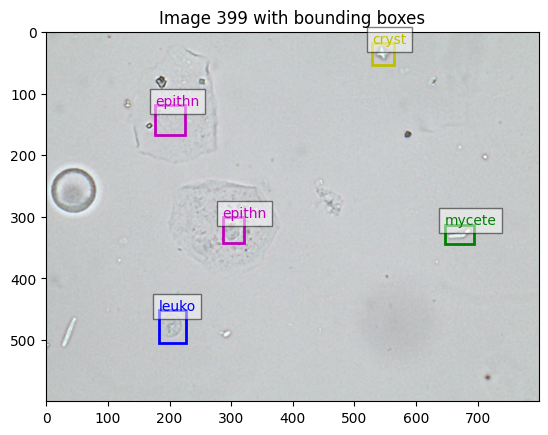

In [ ]:
# Choose a random image from the dataset
random_index = random.randint(0, len(train_dataset) - 1)
sample_image, sample_target = train_dataset[random_index]

# Convert the image to a NumPy array for display
image = sample_image.permute(1, 2, 0).numpy()

# Get bounding boxes and labels
boxes = sample_target['boxes']
labels = sample_target['labels']

# Define a list of distinct colors for different labels
distinct_colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']  # Add more colors if needed
# Create a figure and axes
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(image)

label_map = dataset.label_map
# Loop through the bounding boxes and labels
for i in range(len(boxes)):
    xmin, ymin, xmax, ymax = boxes[i]
    label_index = labels[i].item()  # Get the integer label
    label_name = [k for k, v in label_map.items() if v == label_index][0]
    
    #choose random color from distinct_colors list
    color = distinct_colors[label_index % len(distinct_colors)]

    rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin, ymin, label_name, fontsize=10, color=color, bbox=dict(facecolor='white', alpha=0.5))  # Add label text

# Show the plot
plt.title(f"Image {random_index} with bounding boxes")
plt.show()

In [ ]:
from torchvision.transforms import ToTensor
transforms = ToTensor()

In [81]:
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load the Mask R-CNN model pre-trained on COCO dataset
model = maskrcnn_resnet50_fpn(pretrained=True)

# Get the number of input features for the box predictor
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the box predictor with a new one for the desired number of classes
num_classes = len(train_dataset.label_map) + 1  # Include the background class
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 228MB/s] 


In [82]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [83]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [84]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

In [85]:
num_epochs = 3
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device)
    print(f"Epoch {epoch + 1} completed")

Epoch 1 completed
Epoch 2 completed
Epoch 3 completed


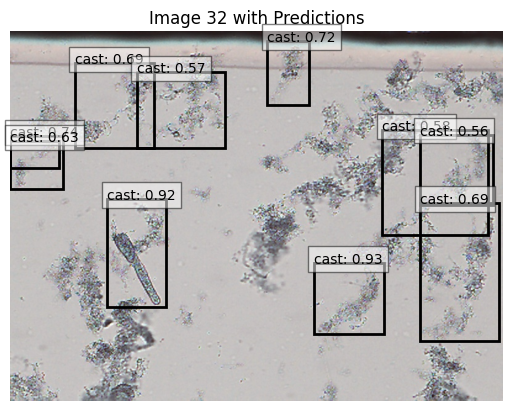

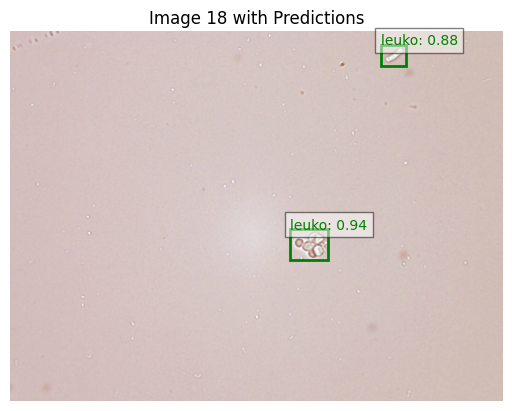

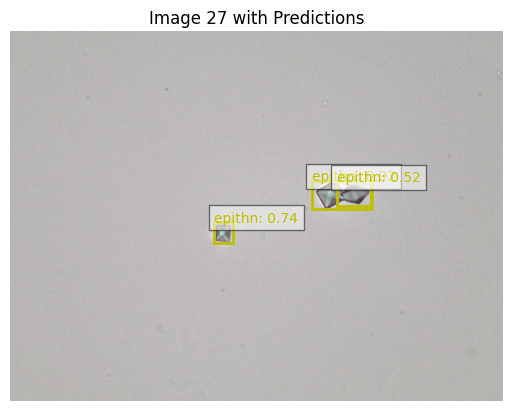

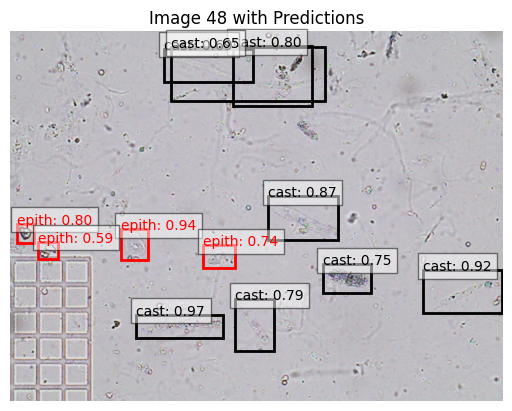

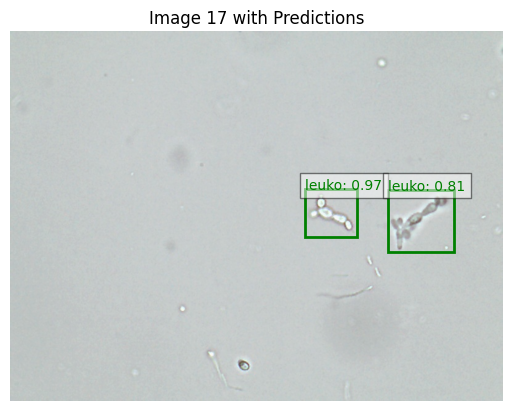

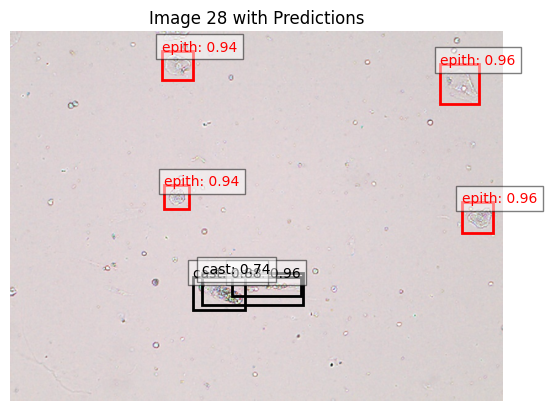

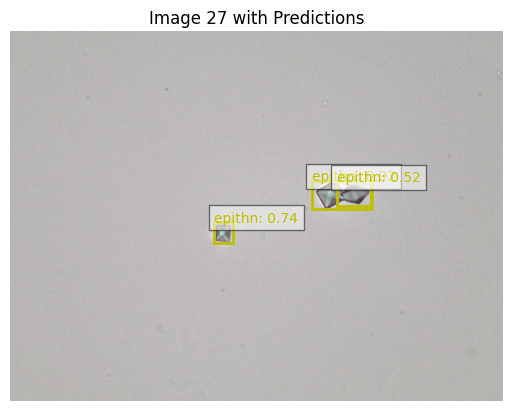

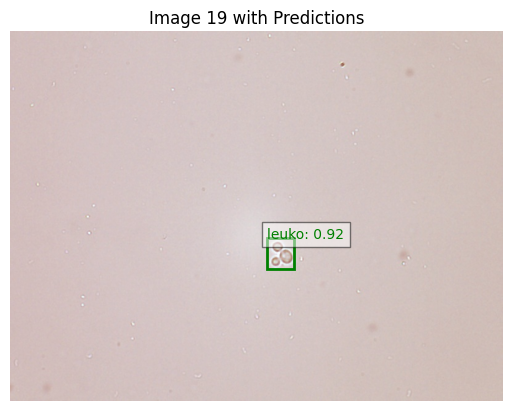

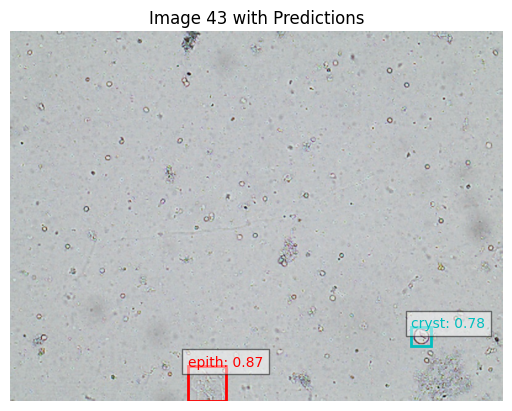

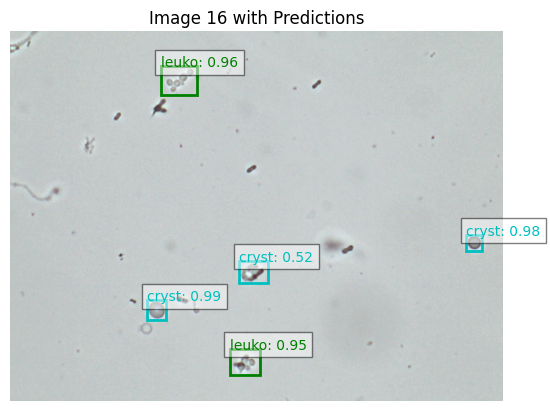

In [86]:
# Function to display predictions for a random image
def test_random_image(model, dataset, device, num_images=10):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for _ in range(num_images):
            random_index = random.randint(0, len(dataset) - 1)
            image, target = dataset[random_index]
            image = image.unsqueeze(0).to(device) # Add batch dimension

            predictions = model(image)

            # Process the predictions (get boxes, labels, scores)
            boxes = predictions[0]['boxes'].cpu().numpy()  # Assuming you want the first image in the batch
            labels = predictions[0]['labels'].cpu().numpy()
            scores = predictions[0]['scores'].cpu().numpy()

            # Filter out low confidence predictions (e.g., scores below 0.5)
            filtered_indices = scores > 0.5  # Change threshold as needed
            boxes = boxes[filtered_indices]
            labels = labels[filtered_indices]
            scores = scores[filtered_indices]

            # Convert the image to a NumPy array for display
            image_np = image[0].permute(1, 2, 0).cpu().numpy()


            # Create a figure and axes
            fig, ax = plt.subplots(1)
            ax.imshow(image_np)
            #get original label name based on label index
            for i in range(len(boxes)):
                xmin, ymin, xmax, ymax = boxes[i]
                label_index = labels[i]
                label_name = [k for k, v in dataset.label_map.items() if v == label_index][0]
                #choose random color from distinct_colors list
                distinct_colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k'] 
                color = distinct_colors[label_index % len(distinct_colors)]

                rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(rect)

                # Display the label and score
                text = f"{label_name}: {scores[i]:.2f}"
                ax.text(xmin, ymin, text, fontsize=10, color=color, bbox=dict(facecolor='white', alpha=0.5))
            plt.title(f"Image {random_index} with Predictions")
            plt.axis('off')
            plt.show()
# Call the function to test random images from the test set
test_random_image(model, test_dataset, device)

### **Report: Analysis of Uploaded Notebook (`mask-rcnn-torch.ipynb`)**

#### **General Overview**
- **Title:** Urine-Sediment-Detection-Mask-Fast-R-CNN
- **Language Used:** Python

#### **Notebook Structure**
- **Focus of Content:**
  - The notebook predominantly features Python code for implementing Mask/Fast R-CNN for object detection.
  - All cells contain code, suggesting that the notebook is focused on practical tasks or experiments rather than documentation or explanation.
  
- **Preview of Code Cells:**
  - **Setup & Installation:** Commands like `pip install` for essential libraries such as `torch`, `torchvision`, and others.
    ```python
    pip install torch torchvision matplotlib pandas
    ```
  - **Data Handling:** Code for loading datasets and preprocessing.
    ```python
    annotations_df = pd.read_csv('/kaggle/input/urinary-sediment/annotations_df.csv')
    images_df = pd.read_pickle('/kaggle/input/urinary-sediment/images_df.pkl')
    ```
  - **Model Definition:** Setting up Mask R-CNN using PyTorch’s torchvision module.
    ```python
    from torchvision.models.detection import maskrcnn_resnet50_fpn
    from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
    ```
  - **Training Logic:** Implementation of training loops and optimization.
    ```python
    def train_one_epoch(model, optimizer, data_loader, device):
        model.train()
        for images, targets in data_loader:
    ```
  - **Visualization:** Plotting images with annotations such as bounding boxes and labels.
    ```python
    import matplotlib.pyplot as plt
    ```